--- DATA VALIDATION REPORT ---
📂 Validiere Run: run_1769345704
📊 Geladene Zeilen: 1,392,466

--- DETAILED VALIDATION REPORT ---


,Rule,Status,Failed Rows,% Passed,Description
0,PK Exists,✅ PASS,0,100.00,Jede Zeile braucht eine ICAO24 ID
1,Lat Range,✅ PASS,0,100.00,Lat muss zwischen -90 und 90 liegen
2,Lon Range,✅ PASS,0,100.00,Lon muss zwischen -180 und 180 liegen
3,Ground Logic,⚠️ WARN,15959,98.85,Widerspruch: Am Boden aber > 4000m Höhe



--- DATA QUALITY DASHBOARD ---


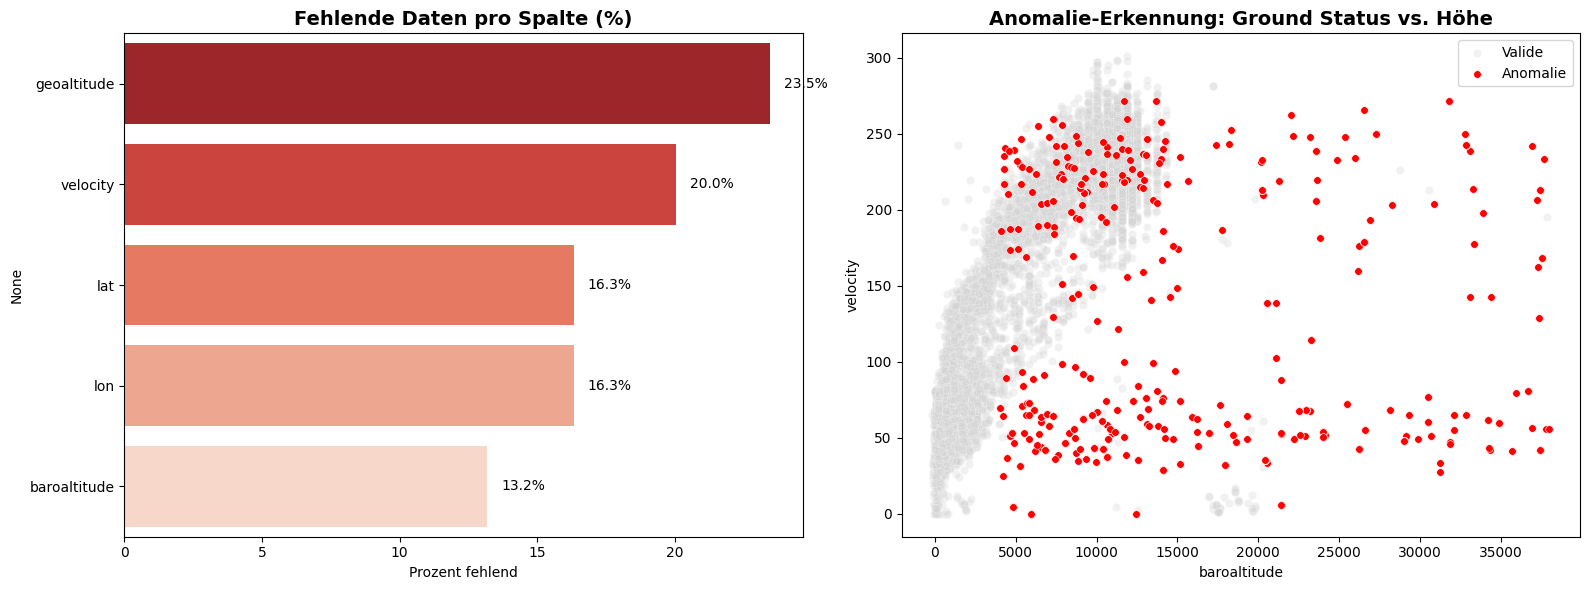

In [1]:
import pandas as pd
import glob
import os
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
# Unterdrückt die nervigen Seaborn/Pandas Warnungen
warnings.filterwarnings("ignore")

print("--- DATA VALIDATION REPORT ---")

BASE_PATH = "../../"

# 1. Daten suchen
search_path = os.path.join(BASE_PATH, "data", "processed", "run_*")
if not glob.glob(search_path):
    search_path = os.path.join(BASE_PATH, "src", "data", "processed", "run_*")

list_of_dirs = glob.glob(search_path)

if not list_of_dirs:
    raise FileNotFoundError("Keine Run-Ordner gefunden.")

latest_run = max(list_of_dirs, key=os.path.getctime)
print(f"📂 Validiere Run: {os.path.basename(latest_run)}")

# --- ROBUSTES LADEN ---
try:
    df = pd.read_parquet(latest_run)
except:
    parquet_files = glob.glob(os.path.join(latest_run, "*.parquet"))
    if not parquet_files:
        raise FileNotFoundError(f"Keine .parquet Dateien in {latest_run}")

    print(f"   (Lese {len(parquet_files)} Partitionen...)")
    df_list = [pd.read_parquet(f) for f in parquet_files]
    df = pd.concat(df_list, ignore_index=True)

# PRÜFUNG: Ist der DataFrame leer?
total_rows = len(df)
print(f"📊 Geladene Zeilen: {total_rows:,}")

if total_rows == 0:
    print("❌ FEHLER: Der Datensatz ist leer. Validierung gestoppt.")
else:
    # =========================================================
    # 🚨 FIX: DATENTYPEN KONVERTIEREN (WICHTIG!)
    # =========================================================
    # Wir zwingen Pandas, aus Strings echte Zahlen zu machen.
    # errors='coerce' wandelt "kaputte" Werte oder leere Strings "" in NaN um.
    numeric_cols = ['lat', 'lon', 'velocity', 'geoaltitude', 'baroaltitude']
    for c in numeric_cols:
        if c in df.columns:
            df[c] = pd.to_numeric(df[c], errors='coerce')

    # =========================================================
    # VALIDIERUNG STARTEN
    # =========================================================
    validation_results = []

    def check(rule_name, condition, description):
        failed_rows = df[~condition]
        fail_count = len(failed_rows)
        # Schutz vor Division durch Null
        percent_ok = 100 - (fail_count / total_rows * 100) if total_rows > 0 else 0

        status = "✅ PASS" if fail_count == 0 else ("⚠️ WARN" if percent_ok > 90 else "❌ FAIL")

        validation_results.append({
            "Rule": rule_name,
            "Status": status,
            "Failed Rows": fail_count,
            "% Passed": round(percent_ok, 2),
            "Description": description
        })

    # 1. Vollständigkeit
    check("PK Exists", df['icao24'].notna() & (df['icao24'] != ""), "Jede Zeile braucht eine ICAO24 ID")

    # 2. Geografische Wertebereiche (Jetzt funktioniert der Vergleich!)
    if 'lat' in df.columns:
        # Wir prüfen nur, wo lat NICHT NaN ist
        valid_lat = (df['lat'].isna()) | ((df['lat'] >= -90) & (df['lat'] <= 90))
        check("Lat Range", valid_lat, "Lat muss zwischen -90 und 90 liegen")

    if 'lon' in df.columns:
        valid_lon = (df['lon'].isna()) | ((df['lon'] >= -180) & (df['lon'] <= 180))
        check("Lon Range", valid_lon, "Lon muss zwischen -180 und 180 liegen")

    # 3. Logik-Check (Consistency)
    if 'onground' in df.columns and 'baroaltitude' in df.columns:
        # Onground String zu Boolean wandeln
        is_onground = df['onground'].astype(str).str.lower() == 'true'
        # Fehler = Am Boden UND höher als 4000m
        logic_error = is_onground & (df['baroaltitude'] > 4000)
        check("Ground Logic", ~logic_error, "Widerspruch: Am Boden aber > 4000m Höhe")

    # =========================================================
    # VISUALISIERUNG
    # =========================================================
    results_df = pd.DataFrame(validation_results)

    print("\n--- DETAILED VALIDATION REPORT ---")
    display(results_df)



print("\n--- DATA QUALITY DASHBOARD ---")
fig, ax = plt.subplots(1, 2, figsize=(16, 6))

# GRAFIK 1: Fehlende Werte (%)
missing_pct = df.isnull().mean() * 100
missing_pct = missing_pct[missing_pct > 0].sort_values(ascending=False)

if not missing_pct.empty:
    sns.barplot(x=missing_pct.values, y=missing_pct.index, palette="Reds_r", ax=ax[0])
    ax[0].set_title("Fehlende Daten pro Spalte (%)", fontsize=14, fontweight='bold')
    ax[0].set_xlabel("Prozent fehlend")
    for i, v in enumerate(missing_pct.values):
        ax[0].text(v + 0.5, i, f"{v:.1f}%", va='center')
else:
    ax[0].text(0.5, 0.5, "Daten sind vollständig!", ha='center')

# GRAFIK 2: Anomalien
if 'onground' in df.columns and 'baroaltitude' in df.columns:
    is_onground = df['onground'].astype(str).str.lower() == 'true'
    # Alles grau plotten (Sampling für Performance)
    sample = df.sample(min(10000, len(df)))
    sns.scatterplot(data=sample, x='baroaltitude', y='velocity', color='lightgrey', alpha=0.3, ax=ax[1], label='Valide')

    # Anomalien rot darüber plotten
    anomalies = df[is_onground & (df['baroaltitude'] > 4000)]
    if not anomalies.empty:
        sns.scatterplot(data=anomalies, x='baroaltitude', y='velocity', color='red', s=30, ax=ax[1], label='Anomalie')

    ax[1].set_title("Anomalie-Erkennung: Ground Status vs. Höhe", fontsize=14, fontweight='bold')
    ax[1].legend()

plt.tight_layout()
plt.show()

In [2]:
import pandas as pd
import glob
import os

# 1. Den neuesten Daten-Ordner finden, den du eben erstellt hast
base_path = "../../data/processed/run_*"
list_of_dirs = glob.glob(base_path)
latest_run = max(list_of_dirs, key=os.path.getctime)

print(f"Lese Daten aus: {latest_run}")

# 2. Daten laden
df_temp = pd.read_parquet(latest_run)

# 3. Die spannenden Spalten anzeigen
cols = ['velocity', 'baroaltitude', 'vertrate', 'onground', 'icao24']
# Nur die ersten 10 Zeilen zeigen, wo auch wirklich Daten drin stehen (drop na)
print(df_temp[cols].dropna().head(10))

# Zeig mir auch kurz die Datentypen, damit ich weiß, ob wir konvertieren müssen
print("\n--- DATENTYPEN ---")
print(df_temp[cols].dtypes)

Lese Daten aus: ../../data/processed\run_1769345704
      velocity        baroaltitude             vertrate onground  icao24
0   130.920692   5791.200000000001                  0.0    False  7c01c2
1   163.201227             3398.52              8.45312    False  a1311e
3   233.718992  10401.300000000001  -12.354560000000001    False  7c6b18
4   224.388419             12192.0                  0.0    False  a600e4
5    49.869237              853.44              1.95072    False  ac9ee1
6   117.862702   685.8000000000001             -1.95072    False  ac0418
7   212.370683             12192.0                  0.0    False  a31533
8   138.934172             1135.38   -7.477760000000001    False  abe0bb
10  124.496511             5311.14              5.20192    False  841794
11  170.805480              8839.2                  0.0    False  ac4410

--- DATENTYPEN ---
velocity        float64
baroaltitude     object
vertrate         object
onground         object
icao24           object
dtype